In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/data/gtFine_trainvaltest.zip -d /content/data/
!unzip /content/drive/MyDrive/data/leftImg8bit_trainvaltest.zip -d /content/data/

Streaming output truncated to the last 5000 lines.
 extracting: /content/data/leftImg8bit/train/jena/jena_000074_000019_leftImg8bit.png  
 extracting: /content/data/leftImg8bit/train/jena/jena_000040_000019_leftImg8bit.png  
 extracting: /content/data/leftImg8bit/train/jena/jena_000020_000019_leftImg8bit.png  
 extracting: /content/data/leftImg8bit/train/jena/jena_000030_000019_leftImg8bit.png  
 extracting: /content/data/leftImg8bit/train/jena/jena_000005_000019_leftImg8bit.png  
 extracting: /content/data/leftImg8bit/train/jena/jena_000059_000019_leftImg8bit.png  
 extracting: /content/data/leftImg8bit/train/jena/jena_000100_000019_leftImg8bit.png  
 extracting: /content/data/leftImg8bit/train/jena/jena_000034_000019_leftImg8bit.png  
 extracting: /content/data/leftImg8bit/train/jena/jena_000089_000019_leftImg8bit.png  
 extracting: /content/data/leftImg8bit/train/jena/jena_000104_000019_leftImg8bit.png  
 extracting: /content/data/leftImg8bit/train/jena/jena_000107_000019_leftImg8bi

In [ ]:
!nvidia-smi

Fri Apr 26 23:03:11 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0              42W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import torch
import os
import numpy as np
import scipy.misc as m
from torch.utils import data
from torch.utils.data import DataLoader
import torch.nn as nn
import sklearn.metrics as skm
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
import time
from PIL import Image
import torchvision.transforms.functional as TF

In [ ]:
# replace device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# replace with location of folder containing "gtFine" and "leftImg8bit"
path_data = "/content/data/"


n_classes = 19
batch_size = 1
num_workers = 0

cuda


In [ ]:
from torch.utils import data
import matplotlib.image as m
from PIL import Image
import torch.multiprocessing as mp
mp.set_start_method('spawn', force=True)

class cityscapesLoader(data.Dataset):
    colors = [
        [128, 64, 128], [244, 35, 232], [70, 70, 70], [102, 102, 156],
        [190, 153, 153], [153, 153, 153], [250, 170, 30], [220, 220, 0],
        [107, 142, 35], [152, 251, 152], [0, 130, 180], [220, 20, 60],
        [255, 0, 0], [0, 0, 142], [0, 0, 70], [0, 60, 100], [0, 80, 100],
        [0, 0, 230], [119, 11, 32]
    ]
    label_colours = dict(zip(range(19), colors))

    def __init__(self, root, split="train", is_transform=True, img_size=(512, 1024)):
        self.root = root
        self.split = split
        self.is_transform = is_transform
        self.n_classes = 19
        self.img_size = img_size if isinstance(img_size, tuple) else (img_size, img_size)
        self.files = {}
        self.images_base = os.path.join(self.root, "leftImg8bit", self.split)
        self.annotations_base = os.path.join(self.root, "gtFine", self.split)
        self.files[split] = self.recursive_glob(rootdir=self.images_base, suffix=".png")
        self.void_classes = [0, 1, 2, 3, 4, 5, 6, 9, 10, 14, 15, 16, 18, 29, 30, -1]
        self.valid_classes = [7, 8, 11, 12, 13, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33]
        self.class_names = [
            "unlabelled", "road", "sidewalk", "building", "wall", "fence", "pole",
            "traffic_light", "traffic_sign", "vegetation", "terrain", "sky", "person",
            "rider", "car", "truck", "bus", "train", "motorcycle", "bicycle"
        ]
        self.ignore_index = 250
        self.class_map = dict(zip(self.valid_classes, range(19)))
        if not self.files[split]:
            raise Exception("No files for split=[%s] found in %s" % (split, self.images_base))
        print("Found %d %s images" % (len(self.files[split]), split))

    def __len__(self):
        return len(self.files[self.split])

    def __getitem__(self, index):
        img_path = self.files[self.split][index].rstrip()
        lbl_path = os.path.join(
            self.annotations_base,
            img_path.split(os.sep)[-2],
            os.path.basename(img_path)[:-15] + "gtFine_labelIds.png"
        )

        img = Image.open(img_path).convert('RGB')
        lbl = Image.open(lbl_path)

        if self.is_transform:
            img, lbl = self.transform(img, lbl)

        return img, lbl

    def transform(self, img, lbl):
      img = img.resize((self.img_size[1], self.img_size[0]), Image.BILINEAR)
      lbl = lbl.resize((self.img_size[1], self.img_size[0]), Image.NEAREST)

      img = np.array(img, dtype=np.float64)
      lbl = np.array(lbl, dtype=int)

      img = img[:, :, ::-1]  # RGB -> BGR might cause negative stride
      img = np.ascontiguousarray(img)  # Ensure the array is contiguous

      img = img.transpose(2, 0, 1)  # NHWC -> NCHW
      img = torch.from_numpy(img).float()
      lbl = torch.from_numpy(lbl).long()
      lbl = self.encode_segmap(lbl)

      return img, lbl


    def encode_segmap(self, mask):
        for _voidc in self.void_classes:
            mask[mask == _voidc] = self.ignore_index
        for _validc in self.valid_classes:
            mask[mask == _validc] = self.class_map[_validc]
        return mask

    def decode_segmap(self, temp):
        r = temp.copy()
        g = temp.copy()
        b = temp.copy()
        for l in range(0, self.n_classes):
            r[temp == l] = self.label_colours[l][0]
            g[temp == l] = self.label_colours[l][1]
            b[temp == l] = self.label_colours[l][2]

        rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
        rgb[:, :, 0] = r / 255.0
        rgb[:, :, 1] = g / 255.0
        rgb[:, :, 2] = b / 255.0
        return rgb

    def recursive_glob(self, rootdir='.', suffix=''):
        return [
            os.path.join(looproot, filename)
            for looproot, _, filenames in os.walk(rootdir)
            for filename in filenames if filename.endswith(suffix)
        ]

In [ ]:
from torch.utils.data import DataLoader

train_data = cityscapesLoader(root=path_data, split='train')
val_data = cityscapesLoader(root=path_data, split='val')

train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers
)

val_loader = DataLoader(
    val_data,
    batch_size=batch_size,
    num_workers=num_workers
)


Found 2975 train images
Found 500 val images


In [ ]:
class UpSampleConv(nn.Module):
    def __init__(self, ch_in, ch_out):
        super(UpSampleConv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(ch_in, ch_out, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.up(x)

class Repeat(nn.Module):
    def __init__(self, ch_out):
        super(Repeat, self).__init__()
        self.ch_out = ch_out
        self.conv = nn.Sequential(
            nn.Conv2d(ch_out, ch_out, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True),
            nn.Dropout(0.7)
        )

    def forward(self, x):
      for i in range(2):
        if i == 0:
          x_rec = self.conv(x)
        x_rec = self.conv(x + x_rec)
      return x_rec

class RRConv(nn.Module):
    def __init__(self, ch_in, ch_out):
        super(RRConv, self).__init__()
        self.repeat_block = nn.Sequential(Repeat(ch_out), Repeat(ch_out))
        self.conv = nn.Conv2d(ch_in, ch_out, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        x = self.conv(x)
        conv_input = self.repeat_block(x)
        return x + conv_input

class R2UNet(nn.Module):
    def __init__(self, img_ch=3, output_ch=19):
        super(R2UNet, self).__init__()
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.channels = [8, 16, 32, 64, 128, 256]

        self.layers = nn.ModuleList()
        self.deconv_layers = nn.ModuleList()
        self.up_layers = nn.ModuleList()

        for i in range(len(self.channels)):
          if i == 0:
            self.layers.append(RRConv(img_ch, self.channels[0]))
          else:
            self.layers.append(RRConv(self.channels[i-1], self.channels[i]))

        for i in range(len(self.channels)-1, 0, -1):
          self.deconv_layers.append(UpSampleConv(self.channels[i], self.channels[i-1]))
          self.up_layers.append(RRConv(self.channels[i], self.channels[i-1]))

        self.conv_final = nn.Conv2d(self.channels[0], output_ch, kernel_size=1, stride=1)

    def forward(self, x):
        conv_out = []
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i < len(self.layers) - 1:
                conv_out.append(x)
                x = self.max_pool(x)


        for i, (deconv_layer, up_layer) in enumerate(zip(self.deconv_layers, self.up_layers)):
            x = deconv_layer(x)
            x = torch.cat((conv_out[-i-1], x), dim=1)
            x = up_layer(x)

        x = self.conv_final(x)
        return x

In [ ]:
from prettytable import PrettyTable
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

count_parameters(model)

In [ ]:
def cross_entropy2d(input, target, weight=None, size_average=True):
    n, c, h, w = input.size()
    nt, ht, wt = target.size()

    # Upsample target to match the size of the input
    if h != ht or w != wt:
        target = F.interpolate(target.float(), size=(h, w), mode="nearest").long()

    # Reshape input and target
    input = input.permute(0, 2, 3, 1).contiguous().view(-1, c)
    target = target.view(-1)

    # Compute cross-entropy loss
    loss = F.cross_entropy(input, target, weight=weight, reduction='mean', ignore_index=250)

    return loss

In [ ]:
class RunningScore:
    def __init__(self, n_classes):
        self.n_classes = n_classes
        self.confusion_matrix = np.zeros((n_classes, n_classes))

    def _fast_hist(self, label_true, label_pred):
        mask = (label_true >= 0) & (label_true < self.n_classes) & (label_pred >= 0) & (label_pred < self.n_classes)
        hist = np.bincount(self.n_classes * label_true[mask].astype(int) + label_pred[mask], minlength=self.n_classes ** 2)
        hist = hist.reshape(self.n_classes, self.n_classes)
        return hist

    def update(self, label_trues, label_preds):
        for lt, lp in zip(label_trues, label_preds):
            self.confusion_matrix += self._fast_hist(lt.flatten(), lp.flatten())

    def get_scores(self):
        TP = np.diag(self.confusion_matrix)
        TN = np.sum(self.confusion_matrix) - np.sum(self.confusion_matrix, axis=1) - np.sum(self.confusion_matrix, axis=0) + np.diag(self.confusion_matrix)
        FP = np.sum(self.confusion_matrix, axis=1) - TP
        FN = np.sum(self.confusion_matrix, axis=0) - TP

        specif_cls = TN / (TN + FP + 1e-6)
        specif = np.nanmean(specif_cls)

        sensti_cls = TP / (TP + FN + 1e-6)
        sensti = np.nanmean(sensti_cls)

        prec_cls = TP / (TP + FP + 1e-6)
        prec = np.nanmean(prec_cls)

        f1 = (2 * prec * sensti) / (prec + sensti + 1e-6)

        return {
            "Specificity": specif,
            "Senstivity": sensti,
            "F1": f1
        }

    def reset(self):
        self.confusion_matrix = np.zeros((self.n_classes, self.n_classes))

In [ ]:
def train(train_loader, model, optimizer, epoch_i, epoch_total):
    model.train()
    loss_list = []
    count = 0

    for images, labels in train_loader:
        count += 1
        images, labels = images.to(device), labels.to(device)


        pred = model(images)
        loss = cross_entropy2d(pred, labels)
        print(loss, end="\r")
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_list.append(loss.item())

        if count % 50 == 0:
            print(f"Image: {count * len(images)} in epoch: [{epoch_i + 1}/{epoch_total}]  and Loss: {loss.item():.4f}")

    return loss_list

In [ ]:
def validate(val_loader, model, epoch_i):
    model.eval()
    running_metrics_val = RunningScore(n_classes=19)
    val_loss = []

    with torch.no_grad():
        for image_num, (val_images, val_labels) in tqdm(enumerate(val_loader)):
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_pred = model(val_images)
            pred = val_pred.argmax(dim=1).cpu().numpy()
            gt = val_labels.cpu().numpy()

            running_metrics_val.update(gt, pred)

    score = running_metrics_val.get_scores()
    running_metrics_val.reset()

    print("Different Metrics were: ", score)
    return score


In [ ]:
def find_best_saved_model(path):
    min_loss = float('inf')
    best_model_path = None

    for filename in os.listdir(path):
        if not filename.endswith('.pt'):
            continue
        # remove file extension
        file = filename.split('.')[0]
        loss = file.split('_')[-2:]
        loss = float(loss[0] + '.' + loss[1])

        if loss < min_loss:
            min_loss = loss
            best_model_path = os.path.join(path, filename)

    return best_model_path

In [ ]:
if __name__ == "__main__":

    # Hyperparameters
    learning_rate = 1e-6
    train_epochs = 13

    model = R2UNet().to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Load Best Model if present
    best_model_path = find_best_saved_model('/content/drive/MyDrive/models')

    if best_model_path:
        checkpoint = torch.load(best_model_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        print(f"Current Best Model Loss: {checkpoint['loss']}")


    loss_all_epochs = []
    metrics_all_epochs = {"Specificity": [], "Senstivity": [], "F1": []}

    for epoch_i in range(start_epoch, train_epochs):
        print(f"Epoch {epoch_i + 1}\n-------------------------------")

        # Training
        t1 = time.time()
        loss_i = train(train_loader, model, optimizer, epoch_i, train_epochs)
        loss_all_epochs.append(loss_i)
        t2 = time.time()
        print("Training time:", t2 - t1)

        torch.save({
            'epoch': epoch_i,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': round(sum(loss_i)/len(loss_i), 2)
        }, f'/content/drive/MyDrive/models/model_{epoch_i}_{str(round(sum(loss_i)/len(loss_i), 2)).replace(".", "_")}.pt')

        # Validation and Metrics Calculation
        metrics = validate(val_loader, model, epoch_i)

        # Add metrics to dictionary
        for metric_name, metric_value in metrics.items():
            metrics_all_epochs[metric_name].append(metric_value)

Current Best Model Loss: 2.01
Epoch 13
-------------------------------
Image: 50 in epoch: [13/13]  and Loss: 2.5882
Image: 100 in epoch: [13/13]  and Loss: 1.8825
Image: 150 in epoch: [13/13]  and Loss: 1.6126
Image: 200 in epoch: [13/13]  and Loss: 2.5613
Image: 250 in epoch: [13/13]  and Loss: 2.4194
Image: 300 in epoch: [13/13]  and Loss: 1.8720
Image: 350 in epoch: [13/13]  and Loss: 1.6681
Image: 400 in epoch: [13/13]  and Loss: 1.7040
Image: 450 in epoch: [13/13]  and Loss: 2.0726
Image: 500 in epoch: [13/13]  and Loss: 1.5611
Image: 550 in epoch: [13/13]  and Loss: 2.1150
Image: 600 in epoch: [13/13]  and Loss: 1.6970
Image: 650 in epoch: [13/13]  and Loss: 1.7733
Image: 700 in epoch: [13/13]  and Loss: 1.9091
Image: 750 in epoch: [13/13]  and Loss: 1.5937
Image: 800 in epoch: [13/13]  and Loss: 1.5818
Image: 850 in epoch: [13/13]  and Loss: 1.8526
Image: 900 in epoch: [13/13]  and Loss: 2.1765
Image: 950 in epoch: [13/13]  and Loss: 2.2935
Image: 1000 in epoch: [13/13]  and Lo

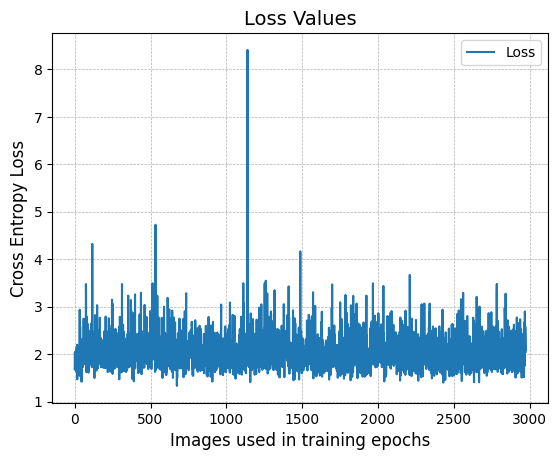

In [ ]:
# Flatten the 2D list of tensors into a 1D list of tensors
loss_1d_list = [item for sublist in loss_all_epochs for item in sublist]

# Plot the loss values
plt.xlabel("Images used in training epochs", fontsize=12)
plt.title("Loss Values", fontsize=14)
plt.ylabel("Cross Entropy Loss", fontsize=12)
plt.plot(loss_1d_list, label="Loss")
plt.grid(linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

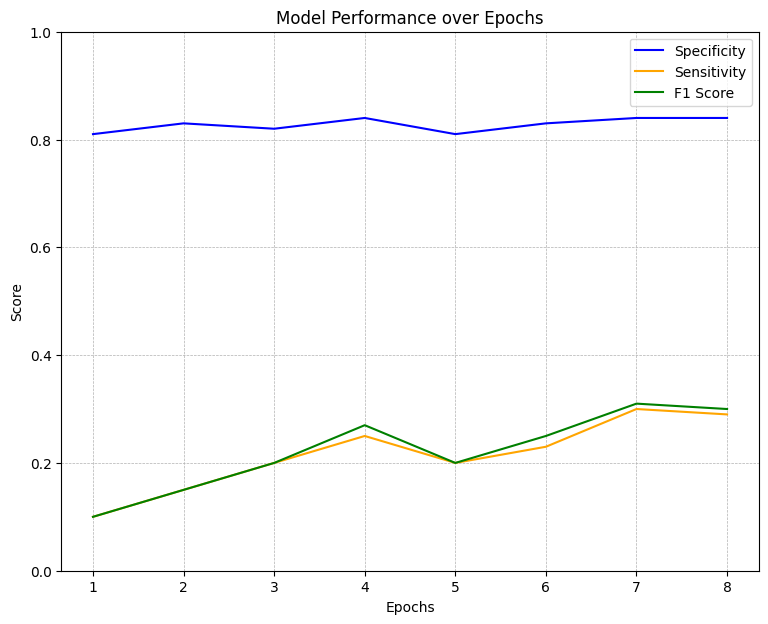

In [1]:
plt.clf()

epochs = range(start_epoch, train_epochs)


plt.plot(epochs, metrics_all_epochs['Specificity'], label='Specificity')
plt.plot(epochs, metrics_all_epochs["Senstivity"], label='Sensitivity')
plt.plot(epochs, metrics_all_epochs['F1'], label='F1 Score')


plt.grid(linestyle='--', linewidth=0.5)

plt.xlabel("Epochs")
plt.ylabel("Score")
plt.title("Model Performance over Epochs")
plt.legend()
plt.ylim(0, 1)
plt.show()



0it [00:00, ?it/s]

(512, 1024, 3)


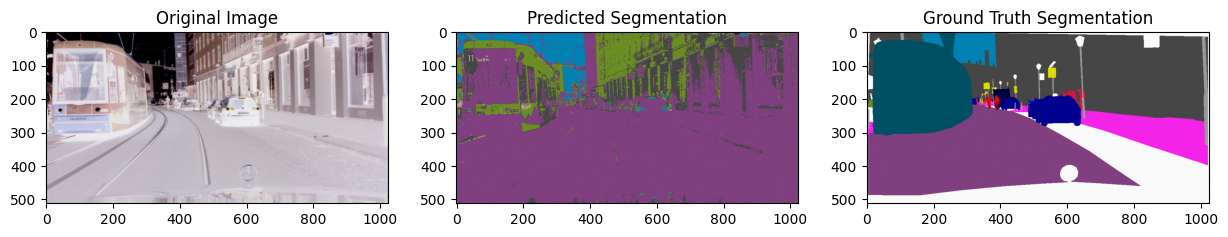

100it [00:16,  6.46it/s]

(512, 1024, 3)


<Figure size 640x480 with 0 Axes>

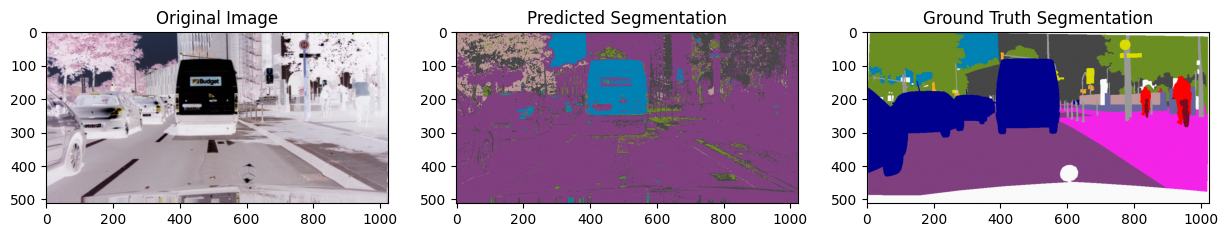

200it [00:33,  6.47it/s]

(512, 1024, 3)


<Figure size 640x480 with 0 Axes>

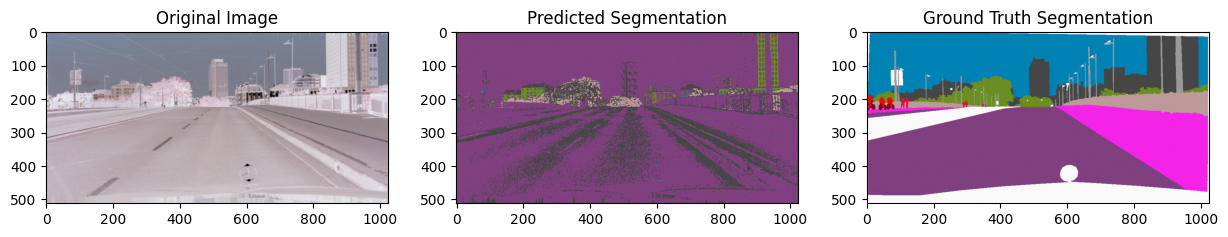

300it [00:50,  6.30it/s]

(512, 1024, 3)


<Figure size 640x480 with 0 Axes>

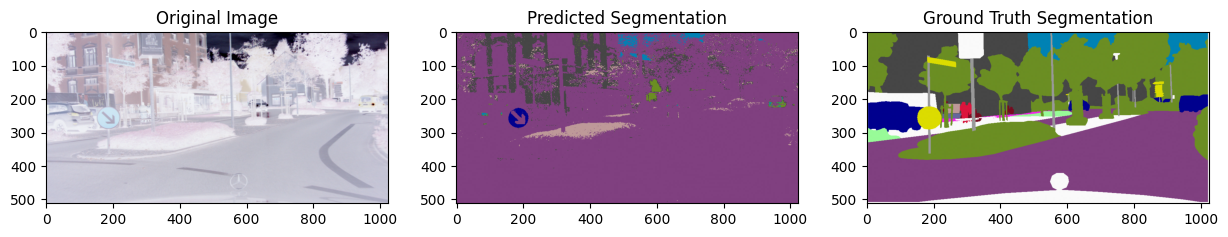

400it [01:08,  6.02it/s]

(512, 1024, 3)


<Figure size 640x480 with 0 Axes>

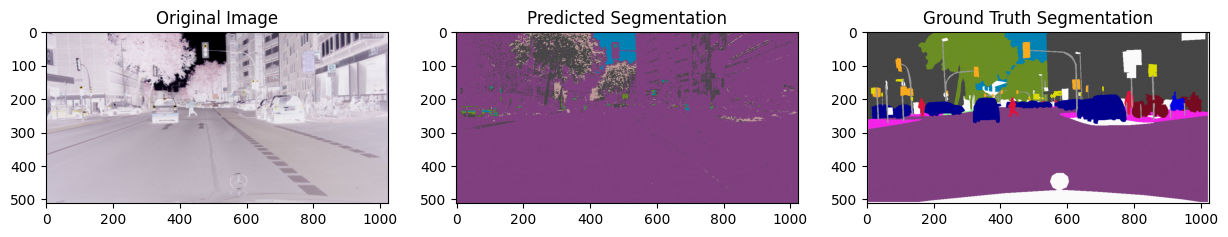

500it [01:25,  5.88it/s]


<Figure size 640x480 with 0 Axes>

In [ ]:
model = R2UNet().to(device)

# Load Best Model if present
best_model_path = find_best_saved_model('/content/drive/MyDrive/models')

if best_model_path:
    checkpoint = torch.load(best_model_path)
    model.load_state_dict(checkpoint['model_state_dict'])

# Set the model to evaluation mode
model.eval()

# Disable gradient calculation during inference
with torch.no_grad():
    for image_num, (val_images, val_labels) in tqdm(enumerate(val_loader)):
        val_images = val_images.to(device)
        val_labels = val_labels.to(device)

        # Model prediction
        val_pred = model(val_images)

        # Convert predictions to numpy array
        prediction = val_pred.argmax(dim=1).cpu().numpy()
        ground_truth = val_labels.cpu().numpy()

        # Display predictions and ground truth for every 100th image
        if image_num % 100 == 0:
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Create a figure with three subplots in a row

            # Plot original image
            img = val_images[0].cpu().permute(1, 2, 0).numpy()
            axes[0].imshow((img * 255).astype(np.uint8))
            axes[0].set_title('Original Image')

            # Plot predicted segmentation
            decoded_pred = val_data.decode_segmap(prediction[0])
            print(decoded_pred.shape)
            axes[1].imshow(decoded_pred)
            axes[1].set_title('Predicted Segmentation')

            # Plot ground truth segmentation
            decoded_gt = val_data.decode_segmap(ground_truth[0])
            axes[2].imshow(decoded_gt)
            axes[2].set_title('Ground Truth Segmentation')

            plt.show()
            plt.clf()
